# (실습) 시계열 데이터 처리 실습

## 실습 개요

1) **실습 목적**

실제 주식 가격 정보 데이터에 여러 시계열데이터의 분석 방법을 적용해봅니다.

2) **수강 목표**

- 문자열 형태 등으로 주어지는 시간 정보를 파싱해 datetime으로 변환할 수 있다.
- 시계열데이터를 구성하는 규칙/불규칙성분들을 이해한다.
- 이동평균 개념을 이해하고 활용할 수 있다.
- 자기회귀모델을 활용해 시계열의 예측을 수행할 수 있다.



### 실습 목차
* 1. 데이터 불러오기
  * 1-1. 데이터셋을 불러와 기본정보 확인
  * 1-2. 데이터셋 전처리 적용

* 2. 시계열 데이터 분석 실습
  * 2-1. 분석대상 데이터 선택
  * 2-2. 정상성 검정 (Stationarity test)
  * 2-3. 시계열데이터의 성분 분해
  * 2-4. 이동평균과 자기회귀 모델링


### 환경 설정

- 패키지 설치 및 임포트

In [30]:
# 패키지 설치 및 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# 시계열 데이터 모델링 패키지 내 함수 임포트
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.seasonal import seasonal_decompose
# 경고메세지를 필터링
from warnings import filterwarnings




###  데이터 셋 개요

* 데이터 셋: New York Stock Exchange
* 데이터 셋 개요: New York Stock Exchange (NYSE) 데이터셋은 뉴욕 주식시장에서 발생한 일일 주식거래 데이터셋입니다. 여러 데이터가 포함되어 있으나 분석 대상인 ```prices.csv``` 데이터는 2010년부터 2016년 말까지에 대한 데이터로, 각 종목별 일일 시가, 종가, 저가, 고가, 거래량에 대한 데이터를 포함합니다.
* 데이터 셋 저작권: CC0: Public Domain
* [Kaggle Dataset page](https://www.kaggle.com/datasets/dgawlik/nyse)


## 1. 실습 데이터셋 준비
```
💡 목차 개요 : 실습에 사용할 NYSE 데이터셋을 불러와 살펴봅니다.
```



### 1-1 데이터셋을 불러와 기본정보 확인
> 데이터셋 사용을 위한 준비를 마치고, 파일을 열어 기본정보를 파악해봅니다.


#### 📝 설명: 데이터셋 파일 다운로드 및 준비

데이터셋의 출처인 캐글 홈페이지에 들어가 실습에 활용할 데이터를 다운로드합니다.
이 실습에는 가격 정보인 `prices.csv`파일만을 사용하므로 다른 파일은
다운로드하지 않아도 괜찮습니다.
* NOTE: 데이터셋 페이지에서 기본으로 선택되어있는 파일인 `fundamentals.csv`는 본 실습에 사용할 파일이 아니므로 주의합니다.

이후 압축파일 형태로 다운로드된 `prices.csv.zip` 파일을 그대로 Colab에 업로드합니다. 업로드는 코랩 왼쪽의 "파일"탭(폴더 모양)에서 수행할 수 있습니다.

다음 셀의 커멘드를 실행해 파일의 압축을 해제하면 실습 파일의 준비가 완료됩니다.


In [31]:
!unzip -o ./data/prices.csv.zip -d ./data  # 다운받은 데이터셋의 압축을 data 폴더 안에 풉니다.

Archive:  ./data/prices.csv.zip
  inflating: ./data/fundamentals.csv  
  inflating: ./data/prices-split-adjusted.csv  
  inflating: ./data/prices.csv       
  inflating: ./data/securities.csv   



#### 👨‍💻 코드 : 준비가 완료된 실습 데이터를 `pandas` 라이브러리로 불러옵니다.
- `pandas`패키지의 `read_csv` 함수를 활용해 데이터셋 파일 불러오기
- 샘플 수, 피쳐 수 등 데이터셋의 기본 정보 파악

In [32]:
# 데이터 불러오기
data = pd.read_csv('./data/prices.csv')

# 불러온 데이터를 확인
data

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0


데이터는 총 851,264개의 데이터포인트와 7개의 변수를 가지고 있습니다.

In [33]:
# 데이터 컬럼 명 확인
data.columns

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='str')

데이터가 날짜(date), 종목명(symbol), 시가(open), 종가(close), 저가(low), 고가(high), 거래량(volumn)에 대한 데이터를 가집니다.

In [34]:
# 데이터 정보 확인
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  str    
 1   symbol  851264 non-null  str    
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), str(2)
memory usage: 45.5 MB


날짜(date)와 종목명(symbol)외의 변수는 모두 가격 혹은 양을 나타내므로 float 변수입니다.

데이터의 요약통계량을 확인합니다.

In [35]:
# 데이터 요약 통계량 확인
data.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,79.879997,79.889999,79.110001,80.610001,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


### 1-2 날짜(date) 데이터의 처리
> 문자열(str) 형태로 나와있는 시간 정보를 수치 형태로 변환합니다.


위의 데이터를 확인해보면 날짜(date) 데이터가 문자열 형태로 저장되어 있는 것을 알
수 있어 이 상태로는 수치형 데이터로서 처리할 수 없는 상태입니다. 이를 연, 월, 일
각각의 숫자가 숫자로서 의미를 갖도록 `pandas` 라이브러리의 `to_datetime`
함수를 사용해 변환해주도록 하겠습니다. 원래 데이터는 시/분/초까지 기록되어 있지만,
데이터 자체는 일별 데이터이므로 모든 값이 `00:00:00`으로 기록되어 있어 분석에 의미는 없습니다. 따라서 이번 실습에서는 제외합니다.

- 시분초 변수를 얻기 위해서는 `data['date'].dt.time` (HH:MM:SS 형태), `data['date'].dt.hour` (시각), `data['date'].dt.minute` (분), `data['date'].dt.second` (초)를 이용합니다.
- 날짜 타입이 '31/09/23' 등으로 다른 형태라면, `to_datetime` 함수의 `format` 옵션을 `%d/%m/%y` 등으로 변경합니다.


#### 👨‍💻 코드 : 날짜 데이터를 파싱
- pandas `to_datetime` 함수 활용해 주어진 문자열(`str`)타입 데이터를 datetime object로 변환
- 변환된 datetime에서 연, 월, 일, 요일 등 정보를 숫자로 가져오기
- 파이썬의 built-in 라이브러리인 `datetime`을 활용해 생성한 object와 비교

In [47]:
# 원래의 string type 날짜를 별도 column으로 백업해줍니다.
data["str_date"] = data["date"].copy()
# 날짜 타입 데이터 변환
# 문자열에 " 00:00:00" 같이 시분초가 포함된 경우, format 인자 없이 변환하거나 적절한 포맷을 지정해야 함
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d', infer_datetime_format=True)
# 만약 일부 값에 시분초가 아예 없을 수 있으므로, 실패시 자동 포맷 추정
if data['date'].isnull().any():
    data['date'] = pd.to_datetime(data['str_date'], errors='coerce')

# 변환 전후의 데이터 타입과 첫 5개 값을 비교해봅니다.
print("원본 데이터")
print("데이터 타입: ", data['str_date'].dtype)
print(data['str_date'][:5])

print("\ndatetime 변환 후")
print("데이터 타입: ", data['date'].dtype)
print(data['date'][:5])

TypeError: to_datetime() got an unexpected keyword argument 'infer_datetime_format'

In [37]:
# datetime의 "일" 정보만 따로 가져오기.
data['date'].dt.day.head()

0     5.0
1     6.0
2     7.0
3     8.0
4    11.0
Name: date, dtype: float64

In [38]:
# datetime의 "요일" 정보만 따로 가져오기
data['date'].dt.dayofweek.head()

0    1.0
1    2.0
2    3.0
3    4.0
4    0.0
Name: date, dtype: float64

비슷하게, year, month등을 활용해 연, 월 정보도 숫자로 가져올 수 있습니다.
"요일"은 인덱싱된 숫자 형태로 나타나 있는데, 월요일부터 일요일까지가 각각 0에서 6까지의 정수로 변환되었습니다.

In [39]:
# python의 built-in library로 datetime object를 생성
dt_example = datetime(2016, 1, 7)

# 생성한 예시 날짜와 데이터의 date영역 크기비교
# 2016년 1월 7일보다 작은 날짜인 첫 3개 값만 True로 나타난다.
print((data["date"] <= dt_example).head())
data["date"].head()

0     True
1     True
2     True
3    False
4    False
Name: date, dtype: bool


0   2016-01-05
1   2016-01-06
2   2016-01-07
3   2016-01-08
4   2016-01-11
Name: date, dtype: datetime64[us]


## 2. 시계열 데이터 분석 실습
```
💡 목차 개요 : 주어진 주식 가격 데이터에서, 한 종목을 선택해 시계열 분석 방법을 적용해봅니다.
```



### 2-1 분석대상 데이터 선택
> 종목을 하나 정해서 시계열 데이터를 분석해봅니다. 여기서는 주식회사 APPLE (symbol은 'AAPL')의 주가 데이터를 사용하겠습니다.



```
# 코드로 형식 지정됨
```


#### 👨‍💻 코드 : APPLE의 주식 데이터 선택
- `symbol` column을 활용해 APPLE의 데이터만 선택
- 데이터 확인 및 시각화

In [40]:
# 주식회사 APPLE (symbol이 'AAPL')의 주식 데이터
apple = data[data['symbol'] == 'AAPL']
apple

,date,symbol,open,close,low,high,volume,str_date
254,NaT,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0,2010-01-04
721,NaT,AAPL,214.599998,214.379993,213.249994,215.589994,150476200.0,2010-01-05
1189,NaT,AAPL,214.379993,210.969995,210.750004,215.230000,138040000.0,2010-01-06
1657,NaT,AAPL,211.750000,210.580000,209.050005,212.000006,119282800.0,2010-01-07
2125,NaT,AAPL,210.299994,211.980005,209.060005,212.000006,111902700.0,2010-01-08
...,...,...,...,...,...,...,...,...
848767,NaT,AAPL,115.589996,116.519997,115.589996,116.519997,14249500.0,2016-12-23
849267,NaT,AAPL,116.519997,117.260002,116.489998,117.800003,18296900.0,2016-12-27
849767,NaT,AAPL,117.519997,116.760002,116.199997,118.019997,20905900.0,2016-12-28
850267,NaT,AAPL,116.449997,116.730003,116.400002,117.110001,15039500.0,2016-12-29


시계열 데이터의 일별 종가를 라인 그래프로 나타냅니다.

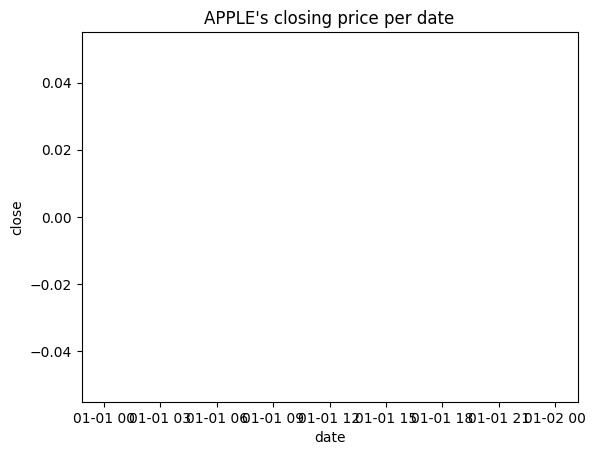

In [41]:
# APPLE의 일별 종가
ax = sns.lineplot(data=apple, x='date', y='close')
ax.set_title("APPLE's closing price per date")
plt.show()


#### 📝 설명: 액면분할로 인한 이상치

데이터를 보면 2014년 6월 9일 주가가 갑자기 급락하였습니다. 이는 주식 가치가 떨어진 것이 아닌, 해당일 APPLE 주식의 [액면분할](https://ko.wikipedia.org/wiki/%EC%A3%BC%EC%8B%9D_%EB%B6%84%ED%95%A0)이 시행되었기 때문입니다.
분할 전후의 가격 정보를 보정해 활용하는 방법도 있지만, 이 실습에서는 적용하지 않고
해당 시점 이전의 데이터는 버린 후 나머지 뒤쪽 데이터만 활용해보도록 하겠습니다.


#### 👨‍💻 코드 : 특정 시점을 기준으로 데이터를 나누기
- 주식의 액면분할 시점을 datetime object로 생성
- 위 시점을 기준으로 가격 데이터를 분할
- 분할 결과를 시각화해 확인

원본 데이터 샘플수: 1762
액면분할 후 데이터 샘플수: 0


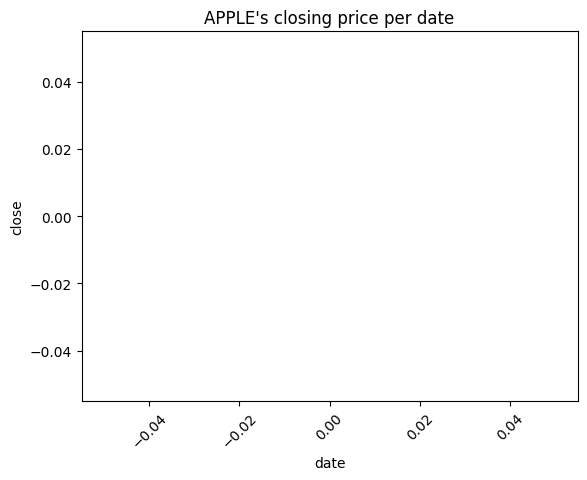

In [42]:
# 샘플수 비교
print(f"원본 데이터 샘플수: {len(apple)}")

# 액면분할 시점을 datetime object로 만들기
day_split = datetime(2014, 6, 9)

# "date"가 분할시점 이후인 데이터만 남기기
apple = apple[apple["date"] >= day_split]

print(f"액면분할 후 데이터 샘플수: {len(apple)}")

# 남은 데이터를 시각화
fig = sns.lineplot(data=apple, x='date', y='close')
fig.tick_params(axis='x', labelrotation=45)
fig.set_title("APPLE's closing price per date")
plt.show()

### 2-2. 정상성 검정 (Stationarity test)

#### 📝 설명: 정상성(Stationarity)과 정상성 검정(Stationarity test)

정상성(Stationarity)은 시계열 데이터의 통계적 특성이 시간에 따라 일정하게 유지되는 성질을 의미합니다. 즉, 평균, 분산, 공분산 등이 시간에 따라 변하지 않는다는 것입니다.

시계열 데이터가 정상성을 가지면 예측 모델링이 더욱 용이해집니다. 왜냐하면, 우리는 데이터의 미래 행동이 과거 행동과 유사할 것이라는 가정 하에 예측 모델을 만들기 때문입니다.

정상성 검정(Stationarity test)은 시계열 데이터가 정상성을 가지고 있는지 확인하는 방법입니다. 대표적인 정상성 검정 방법으로는 Dickey-Fuller 검정, KPSS 검정 등이 있습니다.

여기에서는 Augmented Dickey-Fuller 검정방식을 사용해 정상성 검정을
진행해보도록 하겠습니다. 만약 데이터에 정상성이 있다면 결과의 p-value가 매우
작은 값으로 나오게 됩니다.


#### 👨‍💻 코드 : 정상성 검정 및 결과 확인
- `statsmodels`패키지의 `adfuller`함수를 활용해 Augmented
Dickey-Fuller 방식의 정상성 검정을 수행합니다.
- 결과를 출력해 확인합니다.

In [45]:
# stationary test
if apple['close'].dropna().empty:
    print("Error: 'close' column is empty after dropping NaN values. Stationarity test cannot be performed.")
else:
    try:
        dftest = adfuller(apple['close'].dropna())
        # 결과값을 잘 보여주기 위한 함수
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
    except ValueError as e:
        print("Error: 'close' column is empty after dropping NaN values. Stationarity test cannot be performed.")

Error: 'close' column is empty after dropping NaN values. Stationarity test cannot be performed.


결과에서 p-value를 유심히 보면 값이 0.222412 로 나타나있습니다. 이는 일반적으로 많이 사용하는 p-value의 임계값 0.05 보다 큰 수치이므로 이 데이터가
non-stationary, 정상성을 가지지 않은 데이터임을 알 수 있습니다.

### 2-3. 시계열데이터의 성분 분해
> 시계열데이터를 여러 구성성분으로 나누어 예측가능한 패턴이 있는지 확인해봅니다.



#### 📝 설명: 시계열데이터의 구성성분

시계열 데이터는 일반적으로 네 가지 주요 구성 성분으로 분해될 수 있습니다.

**추세(Trend)성분:** 시간이 지남에 따라 시계열 데이터가 보이는 전반적인 방향 또는 경향을 나타냅니다. 예를 들어, 회사의 매출이 점차 증가하는 경우, 이는 '상향 추세'를 나타냅니다.

**계절(Seasonal)성분:** 일정한 시간 간격으로 반복되는 변동을 나타냅니다. 예를 들어, 매년 여름에 아이스크림 판매량이 증가하는 경우, 이는 '계절성'을 나타냅니다.

**주기(Cyclical)성분:** 일정하지 않은 시간 간격으로 반복되는 변동을 나타냅니다. 이는 경제 주기나 비즈니스 주기와 같은 장기적인 패턴을 포함할 수 있습니다.

**불규칙(Irregular)성분:** 예측할 수 없는 무작위 변동을 나타냅니다. 이는 자연재해, 경제적 충격 등 예측할 수 없는 이벤트에 의해 발생할 수 있습니다.

이중 앞의 세가지는 **규칙성분**으로 시계열 데이터의 예측에 중요한 역할을 합니다.  
다음 코드를 활용하면 주어진 데이터에 **계절성분해**를 적용해 추세성분과 계절성분, 그리고 나머지 불규칙 성분으로 나누어볼 수 있습니다.  

#### 👨‍💻 코드 : 시계열데이터 분해
- `statsmodels` 패키지의 `seasonal_decompose`를 활용해 APPLE 주가 데이터를 분해

In [ ]:
# 날짜 변수를 더 잘 시각화하기 위해 데이터 인덱스에 date 변수 넣기
apple.set_index('date', inplace=True)

In [ ]:
# 계절성 변동의 주기 값 설정
period = 50

# 시계열데이터의 계절성 분해 방법 적용
result = seasonal_decompose(apple['close'], model='addictive', period=period)

# 결과 시각화
fig = result.plot()
fig.set_size_inches((10, 6))
plt.show()

#### 📝 설명 : 계절성 분해와 주식 데이터

계절성 분해는 데이터에 일정한 주기로 반복되는 계절성이 있을 때 의미가 있지만 주식
데이터는 이러한 패턴을 가지지 않으며 완전한 랜덤에 가까운 움직임을 보입니다.
위의 결과는 단순 실습 목적으로 임의로 설정한 주기(50일)에 따르는 패턴이 있다고
가정한 상태에서 나온 결과이므로 추세도 불규칙하게 움직이고, 남아있는 불규칙성분의
크기도 작지 않아, 가격 예측으로 활용하기에 의미가 있는 결과는 아닙니다.




### 2-4. 이동평균과 자기회귀 모델링
> 실습 데이터에 이동평균(Moving Average)과 자기회귀(AutoRegressive)모델링을 적용해봅니다.



#### 📝 설명: 이동 평균 (Moving Average)

p 기간 안의 시계열 값을 평균하여 시간 t의 추세-주기를 측정합니다. 예를 들어 오늘의 5일 이동평균 값은 이전 5일의 값의 평균을 의미합니다. 이를 통해 smoothing 효과를 가질 수 있습니다. 시기가 비슷(전후 몇시점 이내)하면 값이 비슷할 것으로 예상할 수 있습니다.

이동 평균(Moving Average)은 시계열 데이터를 부드럽게 만들거나 노이즈를 줄이는
데 사용되는 기법입니다. 이동평균값은 연속된 데이터 포인트들의 평균값을 계산하는 방식으로 작동하는데, 예를 들어 7일 이동 평균은 각 날짜에 대해 그 날짜와 그 전 6일 동안의 평균값으로 계산합니다.

이동 평균을 활용하면 시계열 데이터에서 단기적인 변동을 제거하고, 장기적인 추세를 더 잘 확인할 수 있습니다.



#### 👨‍💻 코드 : 이동평균값 계산
- `pandas` 라이브러리의 `rolling` 함수를 이용하여 이동평균을 계산합니다.


In [ ]:
# 원본 데이터셋을 복사해 이동평균값을 추가로 저장할 데이터프레임을 생성
apple_with_MA = apple.copy()

# APPLE 주식 가격의 5일, 10일 이동평균을 계산해 별도 column으로 저장
apple_with_MA['MA5'] = apple['close'].rolling(5).mean()
apple_with_MA['MA10'] = apple['close'].rolling(10).mean()

# 처음 100개 값만 선택해 결과를 시각화.
ax = sns.lineplot(data=apple_with_MA[['close', 'MA5', 'MA10']][:100], dashes=False, markersize=5, marker='o')
ax.set_title("APPLE's closing price and moving average")
plt.show()

#### 📝 설명 : 이동 평균과 주식 데이터

APPLE의 종가 데이터에 이동평균 (5)와 이동평균 (10)을 적용한 그래프입니다. 이동평균 데이터는 5, 10 기간동안 평균 처리함으로써 단기적인 변동을 제거하여 원래 데이터보다 더 부드러운 곡선을 이루고 있는 것을 확인할 수 있습니다. 단기적으로 오르내리는 값들에 집중하기 보다 장기적인 추세나 변동을 전반적으로 보고자 할 때는 이렇게 이동평균을 사용할 수 있습니다.

#### 📝 설명: 자기회귀모델 (Auto-Regressive model)

자기회귀모델은, 시계열 데이터의 특정 시점($t$)에서의 값을 예측(회귀)하기 위해 그
직전 시점의 값들을 활용하는 모델링 방식입니다. 예를 들어 시차 2의 자기회귀모델 ($AR(2)$)은 내일의 기온 ($X_t$)을
예측하기 위해 오늘($X_{t-1}$)과 어제($X_{t-2}$)의 기온 정보를 활용하는 방식입니다.

다음 코드에서는 APPLE 주가 데이터에서 5개 시차를 가지는 자기 회귀 모델을 fitting합니다. 즉, 각 시점이 1,2,3,4,5개 이전 시점의 데이터로부터 영향을 받는 AR 모델을 적용합니다.

#### 👨‍💻 코드 : 자기회귀모델을 실습
- `statsmodels` 라이브러리의 `AutoReg` 함수를 이용해 자기회귀모델을 학습합니다.

In [ ]:
# 자기 회귀 모델을 fitting
model = AutoReg(apple['close'], lags=5)
result = model.fit()

# 결과를 출력
print(result.summary())

여러 숫자가 나오지만, 유의해야할 점은 이 모델이 통계적으로 얼마나 유의하게 나타났는지를 확인하는 것입니다. 두번째 단락의 각 변수 L1, ..., L5는 시차1, ..., 시차5를 의미하며 5번째 컬럼의 `P>|z|`로 나타난 p-value로부터 각 변수의 통계적 유의성을 확인할 수 있습니다. 위의 결과에 따르면, 상수항과 L1 변수만이 통계적으로 유의한 변수로 나타났습니다.


추가적으로, Log Likelihood는 클수록, AIC, BIC는 작을수록 좋은 AR 모델이라는 의미입니다. 단일 모델로만 비교하기 어렵기 때문에 다른 모델과의 값이나 통계적 검정을 이용합니다. 또한, `coef`로부터 자기회귀모델 식을 계산할 수 있습니다.


#### 👨‍💻 코드 : 자기회귀 모델 학습결과의 시각화
- 위에서 적합한 모델을 기반으로 데이터가 관측된 이후인 2017년의 APPLE의 주가에 대해서 예측하고 이를 시각화합니다.

In [ ]:
filterwarnings(action='ignore')  # python warnings를 무시하는 옵션

def plot_prediction(data, pred_start, pred_end, result):
    # 관측된 데이터의 샘플 수
    n_samples = len(data.index)

    # 예측할 날짜들 정의
    pred_dates = pd.date_range(start=pred_start, end=pred_end)
    pred_index = list(pred_dates)

    # 기존 관측된 날짜와 예측할 날짜에 대해 예측하기
    prediction = result.get_prediction(end=n_samples + len(pred_dates))

    # 예측값의 평균과 신뢰구간 계산
    pred_mean = prediction.predicted_mean[n_samples + 1:]
    pred_lower = prediction.conf_int()['lower'][n_samples + 1:]
    pred_upper = prediction.conf_int()['upper'][n_samples + 1:]

    # 시각화
    fig, ax = plt.subplots(figsize=(10,6))
    # 기존 관측된 시계열 데이터
    sns.lineplot(data=data)
    # 예측값과 신뢰구간 시각화
    ax.plot(pred_index, pred_mean, label='prediction', zorder=2)
    ax.fill_between(pred_index, pred_lower, pred_upper, color="gray", alpha=0.5, label='95% confidence interval', zorder=1)

    # 그림 설정
    ax.legend(loc='upper right')
    plt.title(f'Prediction from {pred_start} to {pred_end}')
    plt.show()

In [ ]:
# 2017년에 대해서 예측하기
plot_prediction(data=apple['close'], pred_start='2017-01-01', pred_end='2017-12-31', result=result)

신뢰구간이 너무 넓어 크게 의미있는 예측은 아니지만, 결과가 잘 시각화되었습니다.

본 실습에 활용한 주식 데이터는 상당히 불규칙한 움직임을 보이는 데이터이므로
위에서 실습한 통계적 분석방법들로 분석하는데에 한계가 있었습니다. 하지만 좀더 예측
가능하고 규칙적인 데이터셋에 대한 분석을 수행하는 경우나, 고도화된 시계열 모델 혹은 딥러닝 기반의 모델링 등
좀더 고도화된 방법과 함께 활용하는 경우, 이러한 분석방법이 큰 도움이 될 수 있습니다.